In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.stats import norm

Decoder:

In [76]:
img_shape = (200, 200, 1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

This is the function that samples from latent_space:

In [77]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                             mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

Now let's create our decoder:

In [78]:
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(decoder_input)

x = layers.Reshape(shape_before_flattening[1:])(x)

x = layers.Conv2DTranspose(32, 3,
                          padding='same',
                          activation='relu',
                          strides=(2, 2))(x)

x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)

z_decoded = decoder(z)

In [79]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        k1_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + k1_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
y = CustomVariationalLayer()([input_img, z_decoded])

In [127]:
vae = Model(input_img, y)
vae.compile(optimizer='adam', loss=None)
vae.summary()

W0516 23:26:15.314415 139656018949952 training_utils.py:1152] Output custom_variational_layer_3 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_3.


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 200, 200, 1) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 200, 200, 32) 320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 100, 100, 64) 18496       conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 100, 100, 64) 36928       conv2d_17[0][0]                  
___________________________________________________________________________________________

In [99]:
# def to_gray(x):
#     image_gray = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
#     return image_gray

In [100]:
# data_gray = np.ones(x.shape[0])
# for i in np.arange(x.shape[0]):
#     image = x[i]
#     image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     data_gray[i] = image_gray

In [101]:
# x_gray = [to_gray(image) for image in x]

In [102]:
import os
# os.chdir('/Users/RHedg/DATA 2040')
x = np.load('images_clean_grey-spiral.npy')
x = x[:, :, :, np.newaxis]

In [103]:
x.shape

(353, 200, 200, 1)

In [104]:
images_train = x[:300]
images_validation = x[300:]

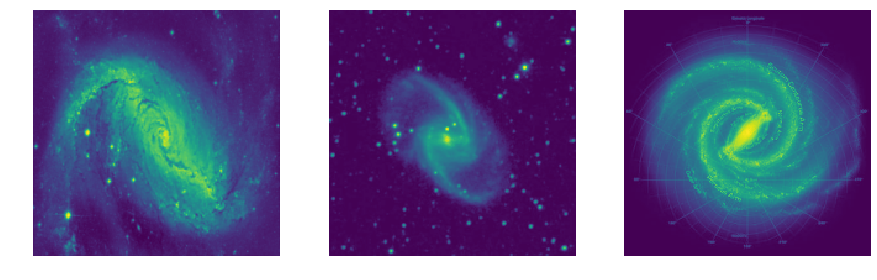

In [105]:
plt.figure(figsize=(15, 8))
plt.subplot(1,3,1); plt.axis('off')
plt.imshow(images_train[0].reshape(200,200))
plt.subplot(1,3,2); plt.axis('off')
plt.imshow(images_train[1].reshape(200,200))
plt.subplot(1,3,3); plt.axis('off')
plt.imshow(images_train[76].reshape(200,200))


In [106]:
# def load_image(x):
#     image_bgr = cv2.imread('celeba/'+x, cv2.IMREAD_GRAYSCALE)
# #     image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
#     image_resize = cv2.resize(image_bgr, (28,28))[:,:,np.newaxis]
#     return image_resize

In [107]:
# images_train = [load_image(image) for image in os.listdir('celeba')[:1000]]
# images_validation = [load_image(image) for image in os.listdir('celeba')[170000:170050]]

In [108]:
# images_train = np.array(images_train) / 255.0
# images_validation = np.array(images_validation) / 255.0

In [109]:
images_train.shape

(300, 200, 200, 1)

In [128]:
vae.fit(images_train, y=None,
        shuffle=True,
        epochs=75,
        batch_size=batch_size,
        validation_data=(images_validation, None))

Train on 300 samples, validate on 53 samples
Epoch 1/75
300/300 [==============================] - 1s 5ms/sample - loss: 0.4048 - val_loss: 0.4132
Epoch 2/75
300/300 [==============================] - 1s 3ms/sample - loss: 0.4014 - val_loss: 0.4139
Epoch 3/75
300/300 [==============================] - 1s 3ms/sample - loss: 0.4006 - val_loss: 0.4133
Epoch 4/75
300/300 [==============================] - 1s 3ms/sample - loss: 0.4003 - val_loss: 0.4129
Epoch 5/75
300/300 [==============================] - 1s 3ms/sample - loss: 0.4007 - val_loss: 0.4133
Epoch 6/75
300/300 [==============================] - 1s 3ms/sample - loss: 0.4002 - val_loss: 0.4133
Epoch 7/75
300/300 [==============================] - 1s 3ms/sample - loss: 0.4007 - val_loss: 0.4131
Epoch 8/75
300/300 [==============================] - 1s 3ms/sample - loss: 0.4011 - val_loss: 0.4137
Epoch 9/75
300/300 [==============================] - 1s 3ms/sample - loss: 0.4020 - val_loss: 0.4127
Epoch 10/75
300/300 [================

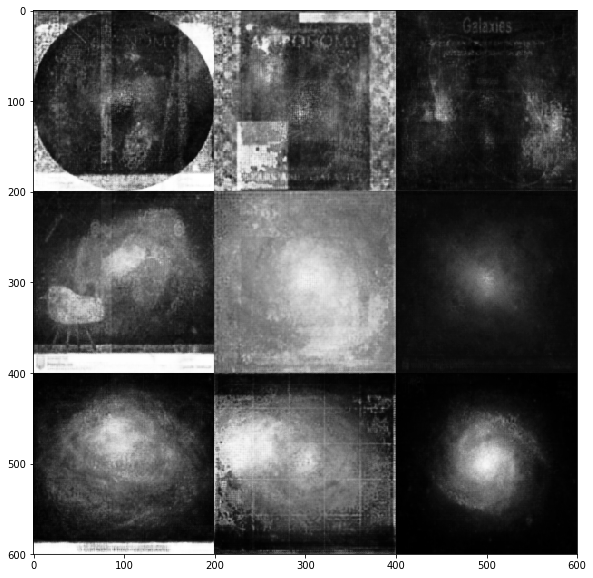

In [129]:
n=3
digit_size = 200
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, .95, n))
grid_y = norm.ppf(np.linspace(0.05, .95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
              j * digit_size: (j + 1) * digit_size] = digit
        
plt.figure(figsize=(10,10))
plt.imshow(figure, cmap='Greys_r')

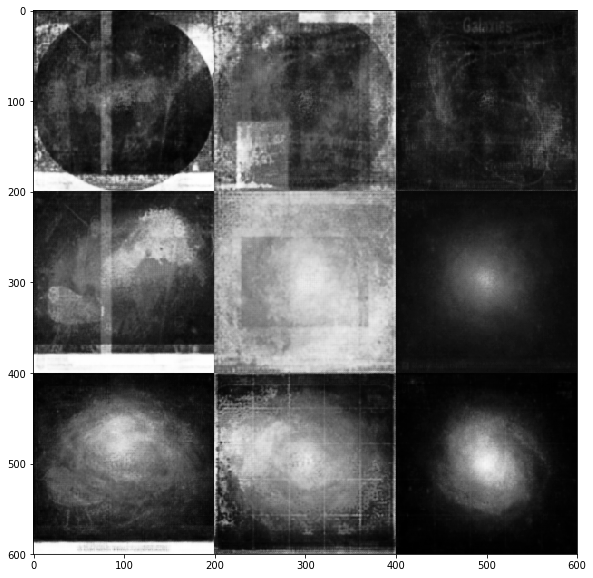

In [111]:
n=3
digit_size = 200
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, .95, n))
grid_y = norm.ppf(np.linspace(0.05, .95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
              j * digit_size: (j + 1) * digit_size] = digit
        
plt.figure(figsize=(10,10))
plt.imshow(figure, cmap='Greys_r')

In [112]:
from sklearn.preprocessing import MinMaxScaler
normal = np.array([np.random.randn(1) for x in np.arange(1000)])
scaler = MinMaxScaler()
scaler.fit(normal)

MinMaxScaler(copy=True, feature_range=(0, 1))

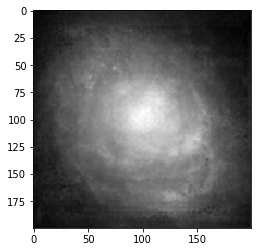

In [165]:
z_sample = np.array([np.random.randn(2)])*2
z_sample = scaler.transform(z_sample)
z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
x_decoded = decoder.predict(z_sample, batch_size=batch_size)
galaxy = x_decoded[0].reshape(digit_size, digit_size)

plt.imshow(galaxy, cmap='gray')

(200, 200)

In [61]:
z_sample[0]

array([1.64485363, 1.64485363])

In [65]:
decoder.predict(z_sample, batch_size=16)[0].shape

(200, 200, 1)